[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.]
[ 0.91210657  0.91210657  0.93314506  0.95039845  0.96415241  0.97479575
  0.98278094  0.98858265  0.99266055  0.99543073  0.99724784  0.99839779
  0.99909932  0.99951156  0.9997447   0.99987152  0.99993783  0.99997117
  0.9999874   0.99999535  1.          1.00000466  1.00001263  1.00002889
  1.0000623   1.00012874  1.00025581  1.00048942  1.00090248  1.00160542
  1.00275767  1.00457841  1.00735415  1.01144021  1.01725353  1.02525471
  1.03591936  1.04970085  1.06698878  1.08806939  1.08806939]
[ 0.77967449  0.77967449  0.81206148  0.84422843  0.87247492  0.89695656
  0.91787855  0.93549143  0.95008394  0.96197322  0.97149275  0.97897936
  0.98476066  0.98914414  0.99240904  0.99480142  0.99653255  0.99778044
  0.99869374  0.99939769  1.00000125  1.00060506  1.00130981  1.00222455
  1.00347466  1.00520903  1.00760593  1.

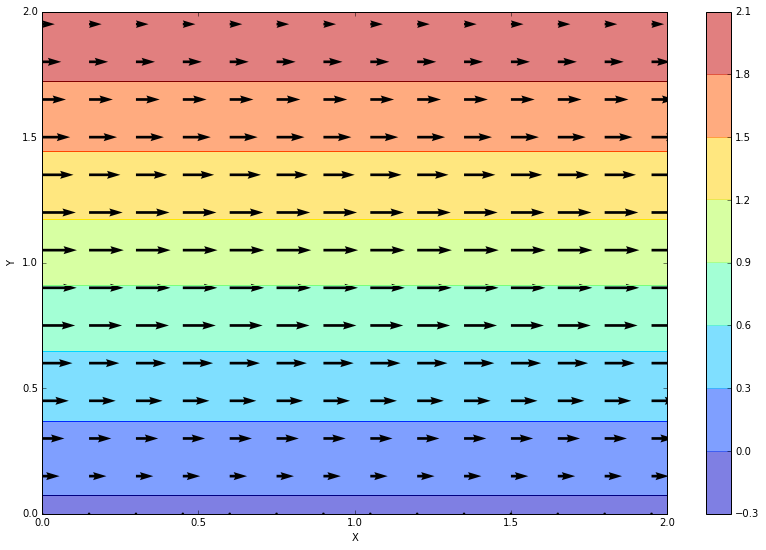

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numba import autojit
%matplotlib inline

def poisson2d(u, v, p, dx, dy, dt, rho, nit):
    ufx = np.roll(u, -1, axis=1)[1:-1,:]
    ubx = np.roll(u, 1, axis=1)[1:-1,:]
    ufy = u[2:, :]
    uby = u[:-2, :]
    uc  = u[1:-1, 1:-1]

    vfx = np.roll(v, -1, axis=1)[1:-1,:]
    vbx = np.roll(v, 1, axis=1)[1:-1,:]
    vfy = v[2:, :]
    vby = v[:-2, :]
    vc  = v[1:-1, 1:-1]
    
    poisson_brackets = rho*(1/dt*((ufy-uby)/(2*dx)+(vfx-vbx)/(2*dy))-\
                           ((ufy-uby)/(2*dx))**2-\
                    2*((ufx-ubx)/(2*dy)*(vfy-vby)/(2*dx))-\
                        ((vfx-vbx)/(2*dy))**2)
    
    def iteration(p):
        pfx = np.roll(p, -1, axis=1)[1:-1,:]
        pbx = np.roll(p, 1, axis=1)[1:-1,:]
        pfy = p[2:, :]
        pby = p[:-2, :]
        pc  = p[1:-1, 1:-1]

#         p[1:-1, :] = ((pfy+pby)*dy**2+(pfx+pby)*dx**2)/(2*(dx**2+dy**2)) -\
#             rho*dx**2*dy**2/(2*(dx**2+dy**2))*poisson_brackets
        p[1:-1, :] = ((pfy + pby)*dy**2 +(pfx+pbx)*dx**2)/\
                    (2*(dx**2+dy**2)) -\
                    (dx*dy)**2/(2*(dx**2+dy**2))*poisson_brackets
        #neumann boundary condition at y
        p[-1,:] = p[-2,:]
        p[0,:] = p[1,:]
        return p

    for q in range(nit):
        p = iteration(p)
    print(p[:,0])
    return p
   
def channelFlow(u, v, p, dx, dy, dt, rho, nu, nt, nit, F):
    udiff = 1
    stepcount = 0
    while udiff > .001:
        un, vn = u.copy(), v.copy()
        
        ufx = np.roll(un, -1, axis=1)[1:-1,:]
        ubx = np.roll(un, 1, axis=1)[1:-1,:]
        ufy = un[2:, :]
        uby = un[:-2, :]
        uc  = un[1:-1, :]

        vfx = np.roll(vn, -1, axis=1)[1:-1,:]
        vbx = np.roll(vn, 1, axis=1)[1:-1,:]
        vfy = vn[2:, :]
        vby = vn[:-2, :]
        vc  = vn[1:-1, :]
        
        p = poisson2d(u, v, p, dx, dy, dt, rho, nit)
        pfx = np.roll(p, -1, axis=1)[1:-1,:]
        pbx = np.roll(p, 1, axis=1)[1:-1,:]
        pfy = p[2:, :]
        pby = p[:-2, :]
        pc  = p[1:-1, :]
        u[1:-1,:] = uc - uc*dt/dx*(uc-uby)- vc*dt/dy*(uc-ubx) -\
            dt/(2*rho*dx)*(pfy-pby) + nu*(dt/dx**2*(ufy-2*uc+uby)+\
            (dt/dy**2*(ufx-2*uc+ubx))) + F*dt
            
        v[1:-1,:] = vc - uc*dt/dx*(vc-vby)- vc*dt/dy*(vc-vbx) -\
            dt/(2*rho*dy)*(pfx-pbx) + nu*(dt/dx**2*(vfy-2*vc+vby)+\
            (dt/dy**2*(vfx-2*vc+vbx)))
        
        u[0,:] = v[0,:] = u[-1,:] = v[-1,:] = 0
        udiff = (np.sum(u)-np.sum(un))/np.sum(u)
        stepcount += 1
    print(stepcount)
    return u, v, p, udiff
        
def run(n=41, nt=10, nit=50, rho=1, nu = 0.1, dt = 1e-2, F=1):
    x, dx = np.linspace(0,2,n, retstep=True)
    y, dy = np.linspace(0,2,n, retstep = True)
    X,Y = np.meshgrid(x,y)

    u = np.zeros((n, n))
    v = np.zeros((n, n))
    p = np.ones((n, n)) 
    u, v, p, udiff = channelFlow(u, v, p, dx, dy, dt, rho, nu, nt, nit, F)
    print(udiff)
    fig, axes = plt.subplots(figsize=(14,9), dpi=100)
    cf = axes.contourf(X,Y,p,alpha=0.5)
    fig.colorbar(cf)
    axes.contour(X,Y,p)
    vn = 3
    axes.quiver(X[::vn,::vn],Y[::vn,::vn], u[::vn, ::vn], v[::vn, ::vn])
    axes.set_xlabel('X')
    axes.set_ylabel('Y')
run()